In [118]:
pip install eeglabio


  Obtaining dependency information for eeglabio from https://files.pythonhosted.org/packages/71/1e/4d4df763057a0e003255603dc2634ce9e0ef352fbaa16b101b2492763212/eeglabio-0.0.2.post4-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [4]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance import dtw_visualisation as dtwvis
from dtw import *
from scipy.interpolate import CubicSpline
from scipy.signal import resample
from scipy.signal import butter
from scipy.signal import filtfilt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
import os
import glob

# Functions

In [5]:
def dtw_align_gait_signals(file_path):
    #Original Tiwe-Warping function obtained from Lea Chabrowsky
    #Input: file_path to the gaitalytics file of interest
    #Output: all_signals_aligned_by_dtw = time-warped signals, ratio_max_min_dtw_distance = distance ratio bewteen time-warped and reference signals
    df = pd.read_csv(file_path)
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)

    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)

    b, a = butter(2, 3, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        xs = np.arange(min_length)
        signal_aligned_by_dtw = resample(cs2(xs), 100)
        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

    ratio_max_min_dtw_distance = max_distance_dtw/min_distance_dtw
    return all_signals_aligned_by_dtw, ratio_max_min_dtw_distance





#This function aligns gait cycle data using dynamic time warping by considering that the
#reference signal is the normalized and filtered mean signal.
#The output of this function is a plot of the normalized and aligned gait cycles
#For this function to work properly the structure of the dataset should be composed of 3 columns:
#'cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'.
def plot_dtw_align_gait_signals(file_path,reference_id=None,EEG=None,ICA=None):
    fig, axs = plt.subplots(2)
    
    df = pd.read_csv(file_path)

    if EEG is not None:
        times = EEG.times
        df = df[df['end_frame']<times[-1]*100]
        eeg_data = EEG.get_data()
        eeg_times = EEG.times
        

    signal_length = np.zeros((len(df),3))
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)
    
    
    if reference_id is not None:
        reference_signal = subset_signal_only_float_values.iloc[reference_id]
        reference_signal = reference_signal[~np.isnan(reference_signal)]
        reference_signal = upsample(reference_signal,100,500)
        #reference_signal = resample(reference_signal, min_length)
        
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    plt.figure(figsize=(10, 6))

    if EEG is not None:
        eeg_set = np.zeros((len(df),eeg_data.shape[0],min_length*5))
        print(eeg_set.shape)
        time_lapses = np.zeros((len(df),2))

    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        gait_cycle_1 = upsample(gait_cycle_1,100,500)
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        

        xs = np.arange(min_length*5)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)

        if EEG is not None:
            time_lapse = [df.iloc[i]['start_frame']/100,df.iloc[i]['end_frame']/100]
            time_lapses[i,:] = time_lapse
            eeg_mask = (eeg_times<time_lapse[1])&(eeg_times>time_lapse[0])
            eeg_data_sel = eeg_data[:,eeg_mask]
            eeg_query = id_query2[id_query2<eeg_data_sel.shape[1]]
            eeg_reference = id_reference2[:len(eeg_query)]
            es2 = CubicSpline(eeg_reference, eeg_data_sel[:,eeg_query],axis=1)
            eeg_aligned_by_dtw = es2(xs)
            eeg_set[i,:] = eeg_aligned_by_dtw

        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

        axs[0].plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        axs[1].plot(np.linspace(0, 100, len(xs2)),signal_aligned_by_dtw2)
        signal_length[i,0] = len(gait_cycle_1)
        signal_length[i,1] = len(signal_aligned_by_dtw)
        signal_length[i,2] = len(signal_aligned_by_dtw2)

    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    if EEG is not None:
        return signal_length,eeg_set,time_lapses
    
    return signal_length

def upsample(signal,low_freq,high_freq):
    n_samples = len(signal)
    signal_up = resample(signal,int(n_samples*(high_freq/low_freq)))
    return signal_up

def align_eeg(file_path,EEG,ICA):
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    times = times - offset
    df = df[df['end_frame']<times[-1]*100]
    eeg_data = EEG.get_data()

    epochs = []
    epochs_ica = []
    max_samples = 0
    for i in range(df.shape[0]):
        t_start = df.iloc[i]['start_frame']/100
        t_end = df.iloc[i]['end_frame']/100
        time_mask = (times>t_start)&(times<t_end)
        eeg_section = eeg_data[:,time_mask]
        #ica_section = ICA[:,time_mask]

        if eeg_section.shape[1] > max_samples:
            max_samples = eeg_section.shape[1]

        epochs.append(eeg_section)
        #epochs_ica.append(ica_section)

    epochs_resampled = np.zeros((df.shape[0],eeg_data.shape[0],max_samples))
    #epochs_ica_resampled = np.zeros((df.shape[0],ICA.shape[0],max_samples))
    for i in range(df.shape[0]):
        epoch_resampled = resample(epochs[i],max_samples,axis=1)
        #epoch_ica_resampled = resample(epochs_ica[i],max_samples,axis=1)
        epochs_resampled[i,:] = epoch_resampled
        #epochs_ica_resampled[i,:] = epoch_ica_resampled
    epochs_ica_resampled = []
    return epochs,epochs_resampled,epochs_ica_resampled

def reconstruct_eeg(raw,epochs_set):
    reconstructed_eeg_data = np.zeros((epochs_set.shape[1],epochs_set.shape[2]*epochs_set.shape[0]))

    for i in range(epochs_set.shape[0]):
        low_idx = i*epochs_set.shape[2]
        high_idx = (i+1)*epochs_set.shape[2]
        reconstructed_eeg_data[:,low_idx:high_idx] = epochs_set[i]
    info = mne.create_info(raw.info['ch_names'],epochs_set[0,:].shape[1],ch_types='eeg')
    reconstructed_eeg = mne.io.RawArray(reconstructed_eeg_data,info)
    return reconstructed_eeg

def annotate_eeg(EEG,file_path):
    
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    times = times - offset
    df = df[df['end_frame']<times[-1]*100]
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)
    t_stamps = []
    for i in range(df.shape[0]):
        t_stamps.append(df.iloc[i]['start_frame']/100 + offset)
    target_nb = ['LHS']*(len(t_stamps))
    annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
    raw_annotated = EEG.copy().set_annotations(annots);
    return raw_annotated


def align_motion(file_path,EEG,epochs_resampled):
    df = pd.read_csv(file_path)
    plt.figure(figsize=(10, 6))
    times = EEG.times
    df = df[df['end_frame']<times[-1]*100]
    eeg_data = EEG.get_data()
    eeg_times = EEG.times

    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)
    
    epoch_length = epochs_resampled.shape[2]
    for i in range(len(subset_signal_only_float_values)):
        signal = subset_signal_only_float_values.iloc[i]
        signal = signal[~np.isnan(signal)]
        signal = resample(signal,epoch_length)
        #reference_signal = resample(reference_signal, min_length)
        plt.plot(signal)
    plt.show()
    '''    
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    '''
    return

def get_epoch(eeg,epochs_resampled,tmin=0,tmax=1,baseline=None):
    t_stamps = []
    for i in range(epochs_resampled.shape[0]):
        t_stamps.append(eeg.times[i*epochs_resampled.shape[2]])
    target_nb = ['LHS']*epochs_resampled.shape[0]
    annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
    raw_annotated = eeg.copy().set_annotations(annots);
    eventss, event_idss = mne.events_from_annotations(raw_annotated);
    epochs = mne.Epochs(eeg, eventss, event_idss, tmin = tmin-0.1, tmax = tmax+0.1, baseline=baseline)
    return epochs

def time_warp_signal(target_signal,file_path,reference_id=None):
    # Here we assume that signal first dim = gait cycles and last dim = time points
    
    fig, axs = plt.subplots(2)
    length_target_signal = target_signal.shape[-1]
    df = pd.read_csv(file_path) 

    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)
    
    
    if reference_id is not None:
        reference_signal = subset_signal_only_float_values.iloc[reference_id]
        reference_signal = reference_signal[~np.isnan(reference_signal)]
        #reference_signal = upsample(reference_signal,100,500)
        reference_signal = resample(reference_signal, length_target_signal)
        
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0

    new_set = np.zeros(target_signal.shape)

    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        gait_cycle_1 = resample(gait_cycle_1,length_target_signal)
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        

        xs = np.arange(length_target_signal)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)
        
        sub_target_signal = target_signal[i]
        ts2 = CubicSpline(id_reference2, sub_target_signal[...,id_query2],axis=-1)
        target_signal_aligned = ts2(xs)
        new_set[i,:] = target_signal_aligned
        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

        axs[0].plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        #axs[1].plot(np.linspace(0, 100, len(xs)),target_signal_aligned)

    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    plt.show()

    
    return new_set

def get_recording_path(subject_id,condition,root_path='C:/Users/haiou/Documents/Cereneo/Data/5_single-subject-EEG-analysis'):
    base_filename = os.path.join(root_path,'sub-'+str(subject_id))
    os.chdir(base_filename)
    for file in glob.glob("*.set"):
        file_identifier = '_'+condition+'_cleaned'
        if file_identifier in file:
            subject_path = os.path.join(base_filename, file)

    return subject_path

def get_analysis_path(subject_id,condition,root_path='C:/Users/haiou/Documents/Cereneo/Data/gaitalytics_data'):
    base_filename = os.path.join(root_path,'S'+str(subject_id),'S'+str(subject_id)+'_'+condition)
    os.chdir(base_filename)
    file_identifiers = ['angles','spatio_temp']
    
    for file in glob.glob("*.csv"):
        if file_identifiers[0] in file:
            file_path_angles = os.path.join(base_filename, file)
        elif file_identifiers[1] in file:
            file_path_spatio_temp = os.path.join(base_filename, file)

    return file_path_angles,file_path_spatio_temp

def get_parameter_path(subject_id,condition,marker='knee',parameter='angles',side='left',coordinate='y',nomalisation='Left-normalised',root_path='C:/Users/haiou/Documents/Cereneo/Data/gaitalytics_data'):
    #get_parameter_path(5,'FB','knee','angles','left','y','Left-normalised')
    base_filename = os.path.join(root_path,'S'+str(subject_id),'S'+str(subject_id)+'_'+condition)
    os.chdir(base_filename)
    directory = glob.glob("*.csv")
    file = [i for i in directory if marker in i and parameter in i and side in i and coordinate in i and nomalisation in i]
    
    return os.path.join(base_filename,file[0])



# Load EEG

c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\pymatreader\utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading C:\Users\haiou\Documents\Cereneo\Data\5_single-subject-EEG-analysis\sub-5\sub-5_FB_cleaned_with_ICA.fdt
<bound method ContainsMixin.get_channel_types of <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 500.0 Hz
>>
Using matplotlib as 2D backend.


C:\Users\haiou\AppData\Local\Temp\ipykernel_190900\1593073594.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(recording_path)
C:\Users\haiou\AppData\Local\Temp\ipykernel_190900\1593073594.py:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(recording_path)


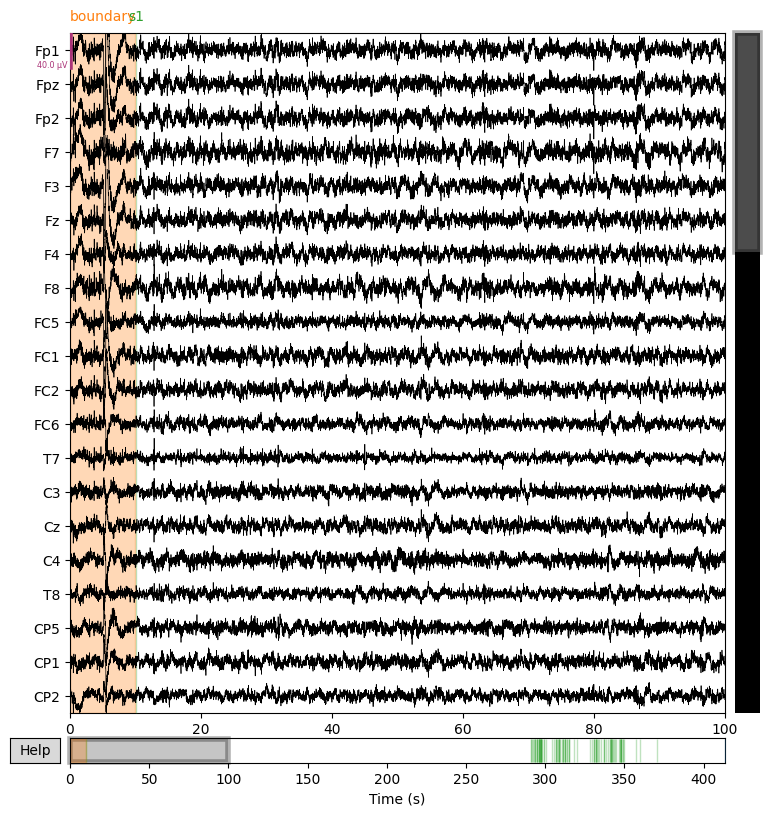

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


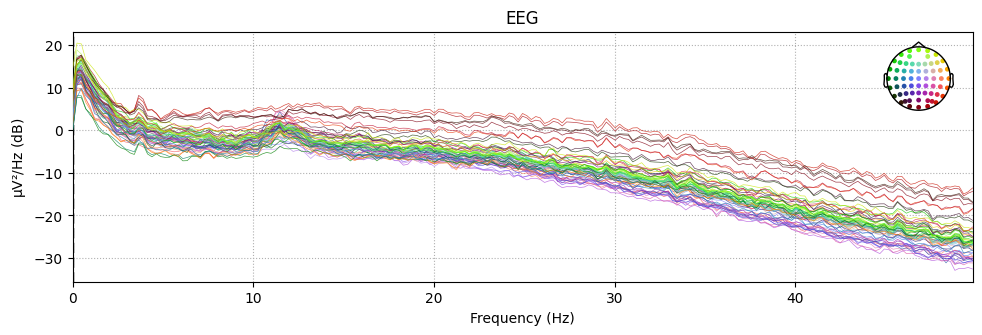

In [7]:
#Load EEG data
subject_id = 5
condition = 'FB'
recording_path = get_recording_path(subject_id,condition)
raw = mne.io.read_raw_eeglab(recording_path)
#EEG channel information
print(raw.info.get_channel_types)
#Plot of EEG data
raw.plot(start=0,duration=100)
plt.show()
#Plot of power density spectrum
raw.plot_psd(picks='eeg',fmax=50)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


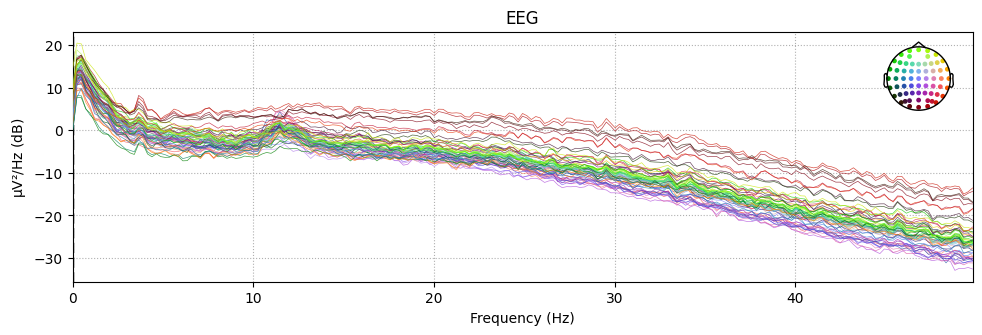

In [19]:
raw.plot_psd(picks='eeg',fmax=50)

## ICA

In [4]:
ica_path = r'C:\Users\haiou\Documents\Cereneo\Data\5_single-subject-EEG-analysis\sub-4\sub-4_ICA_sources.mat'
ica_data = scipy.io.loadmat(ica_path)


In [11]:
print(ica_data['ICA_sources'].shape)
print(raw.get_data().shape)

(19, 366369)
(60, 366369)


In [27]:
ica_sources = ica.get_sources(raw)

In [28]:
ica_sources

<RawEEGLAB | 11 x 107792 (215.6 s), ~9.1 MB, data loaded>

Creating RawArray with float64 data, n_channels=11, n_times=107792
    Range : 0 ... 107791 =      0.000 ...   215.582 secs
Ready.


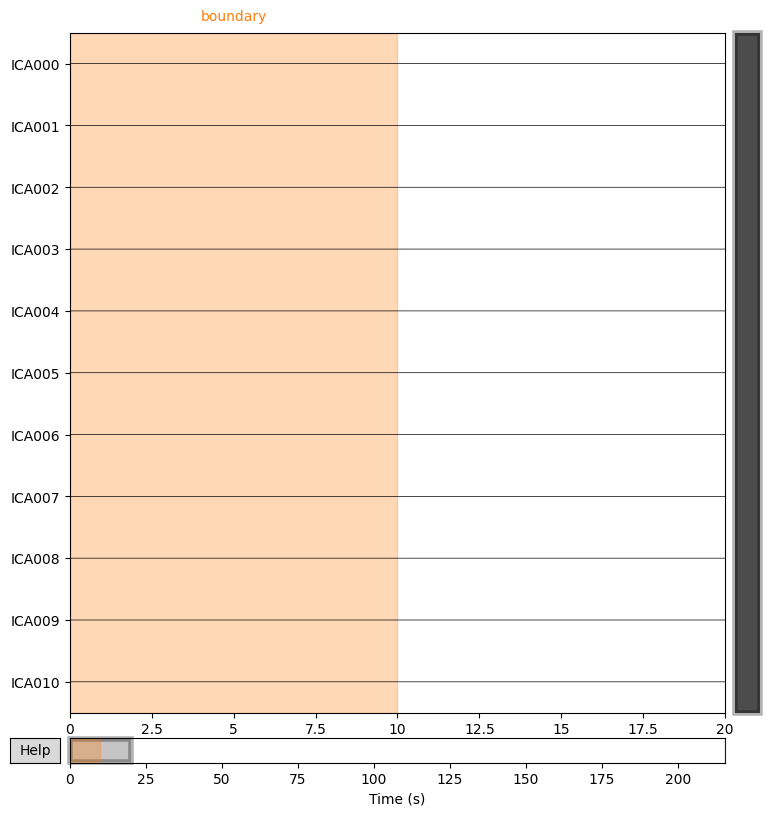

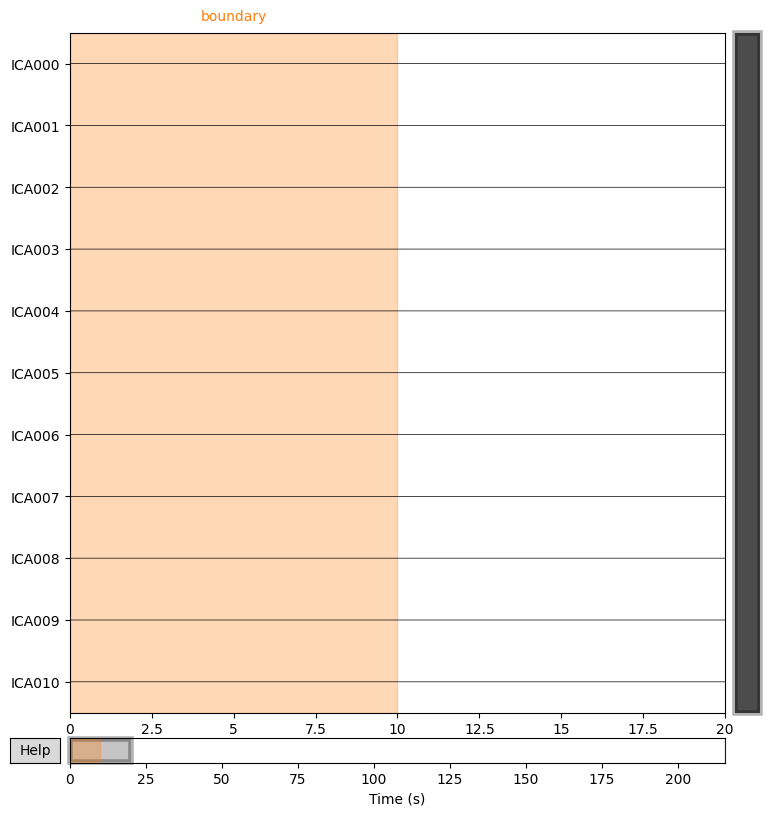

In [29]:
ica.plot_sources(raw)

In [8]:
mne.events_from_annotations(raw)

Used Annotations descriptions: ['BASE-END', 'BASE-START', 'BUT-LEFT-ButtonB-Press', 'BUT-RIGHT-ButtonB-Press', 'BackupLED used - Stim-40-R-walkWarning-281-yellow-1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-003-blue--1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-004-blue--1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-006-yellow--1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-008-yellow--1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-296-none-1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-297-yellow-1-kongruent', 'BackupLED used - Stim-60-L-walkWarning-299-yellow-1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-002-yellow--1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-005-yellow--1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-010-yellow--1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-011-yellow--1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-287-yellow-1-kongruent', 'BackupLED used - Stim-60-R-walkWarning-29

(array([[      0,       0,    3233],
        [    249,       0,       2],
        [  29499,       0,       1],
        ...,
        [1455681,       0,       2],
        [1466642,       0,       1],
        [1466892,       0,    3233]]),
 {'BASE-END': 1,
  'BASE-START': 2,
  'BUT-LEFT-ButtonB-Press': 3,
  'BUT-RIGHT-ButtonB-Press': 4,
  'BackupLED used - Stim-40-R-walkWarning-281-yellow-1-kongruent': 5,
  'BackupLED used - Stim-60-L-walkWarning-003-blue--1-kongruent': 6,
  'BackupLED used - Stim-60-L-walkWarning-004-blue--1-kongruent': 7,
  'BackupLED used - Stim-60-L-walkWarning-006-yellow--1-kongruent': 8,
  'BackupLED used - Stim-60-L-walkWarning-008-yellow--1-kongruent': 9,
  'BackupLED used - Stim-60-L-walkWarning-296-none-1-kongruent': 10,
  'BackupLED used - Stim-60-L-walkWarning-297-yellow-1-kongruent': 11,
  'BackupLED used - Stim-60-L-walkWarning-299-yellow-1-kongruent': 12,
  'BackupLED used - Stim-60-R-walkWarning-002-yellow--1-kongruent': 13,
  'BackupLED used - Stim-60-R-w

In [5]:
df = pd.read_csv('C:/Users/haiou/Documents/Cereneo/ica_data')

In [7]:
df.describe()

Time             1             2             3             4  \
count  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06   
mean   2.933783e+06  1.341820e-03  2.288122e-03 -2.657126e-03  6.476872e-04   
std    1.693822e+06  3.536197e+00  2.737294e+00  1.988921e+00  1.434009e+00   
min    0.000000e+00 -6.838400e+01 -7.352690e+01 -1.101170e+01 -1.464470e+01   
25%    1.466891e+06 -2.145100e+00 -1.587000e+00 -1.344500e+00 -8.631000e-01   
50%    2.933783e+06  1.663000e-01  9.770000e-02 -9.990000e-02  4.130000e-02   
75%    4.400674e+06  2.347500e+00  1.720100e+00  1.225400e+00  9.225000e-01   
max    5.867565e+06  7.863170e+01  4.871810e+01  1.232430e+01  8.929000e+00   

                  5             6             7             8             9  \
count  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06   
mean   3.329283e-04  1.528820e-04  4.522568e-04  5.863289e-04  2.411929e-04   
std    1.470792e+00  1.239165e+00  1.258462e+00  1.442118e+00  1.111774e+00   
min   -1.763140e+01 -1.860600e+01 -1.603630e+01 -7.598990e+01 -1.212510e+01   
25%   -8.851000e-01 -7.504000e-01 -7.765000e-01 -8.219000e-01 -6.700000e-01   
50%    4.550000e-03 -8.100000e-03  1.060000e-02  7.400000e-03  2.070000e-02   
75%    8.924000e-01  7.458000e-01  7.920000e-01  8.395000e-01  6.984000e-01   
max    1.352620e+01  3.552010e+01  1.684680e+01  1.391263e+02  1.857200e+01   

       ...            11            12            13            14  \
count  ...  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06   
mean   ... -3.186742e-04  1.215134e-04 -2.075699e-04  2.408288e-04   
std    ...  8.614761e-01  9.251675e-01  7.785403e-01  7.352873e-01   
min    ... -1.315140e+01 -2.500540e+01 -4.564800e+00 -1.268330e+01   
25%    ... -5.105000e-01 -6.015000e-01 -5.179000e-01 -4.842000e-01   
50%    ... -4.000000e-04  7.300000e-03 -7.750000e-03 -3.000000e-03   
75%    ...  5.105000e-01  6.094000e-01  5.088000e-01  4.797000e-01   
max    ...  9.025400e+00  1.638990e+01  4.762400e+00  1.653460e+01   

                 15            16            17            18            19  \
count  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06  1.466892e+06   
mean   2.030309e-04 -1.134209e-04 -2.921251e-04  1.703290e-04  1.557801e-04   
std    5.788313e-01  5.774161e-01  5.366422e-01  3.583371e-01  2.879198e-01   
min   -5.614800e+00 -1.443550e+01 -1.915880e+01 -1.272760e+01 -3.330300e+00   
25%   -3.833000e-01 -3.825000e-01 -3.462000e-01 -2.242000e-01 -1.895000e-01   
50%    2.000000e-04 -3.800000e-03 -3.300000e-03 -7.300000e-03  1.300000e-03   
75%    3.833000e-01  3.780000e-01  3.411000e-01  2.134000e-01  1.909000e-01   
max    1.124660e+01  1.012200e+01  3.876110e+01  8.326700e+00  5.032500e+00   

                 20  
count  1.466892e+06  
mean  -7.043463e-06  
std    2.549498e-02  
min   -3.198000e-01  
25%   -1.560000e-02  
50%    0.000000e+00  
75%    1.560000e-02  
max    3.142000e-01  

[8 rows x 21 columns]

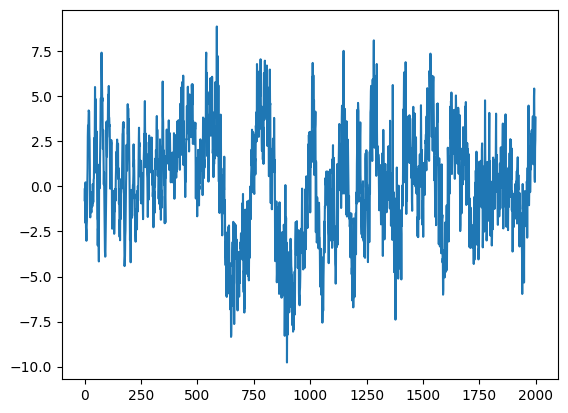

In [9]:
plt.plot(df['1'][0:2000])

# gait data

In [6]:
pd.read_csv(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\spatio_temp.csv")

Unnamed: 0     step_length_left    step_length_right  \
0          metric       Spatiotemporal       Spatiotemporal   
1    cycle_number                  NaN                  NaN   
2               1  0.33247557744929646   0.3174625220722813   
3               2   0.3676844677625383  0.35287897577467314   
4               3  0.35691406557406097  0.38004159494749595   
..            ...                  ...                  ...   
252           251   0.1659503869987423  0.17207709464339596   
253           252  0.15824704262886502  0.18759106898374775   
254           253  0.16475433123733058  0.16763933484714483   
255           254  0.17156983328443065  0.17260056796594914   
256           255  0.17222974023855522   0.1421321274660146   

           stride_length cycle_duration_s_left step_duration_s_left  \
0         Spatiotemporal        Spatiotemporal       Spatiotemporal   
1                    NaN                   NaN                  NaN   
2     0.6499380995215778                  1.11                 0.34   
3     0.7205634435372115                  1.02                 0.34   
4     0.7369556605215569                  1.01                 0.35   
..                   ...                   ...                  ...   
252  0.33802748164213825                   4.7                 0.65   
253   0.3458381116126128                  4.55                  0.6   
254   0.3323936660844754                   5.5                  0.6   
255   0.3441704012503798                  5.24                 0.61   
256  0.31436186770456986                  5.77                 0.52   

    swing_duration_p_left stance_duration_p_left cycle_duration_s_right  \
0          Spatiotemporal         Spatiotemporal         Spatiotemporal   
1                     NaN                    NaN                    NaN   
2      0.3063063063063063     0.6936936936936937                   1.13   
3     0.33333333333333337     0.6666666666666666                   1.05   
4      0.3465346534653465     0.6534653465346535                   1.06   
..                    ...                    ...                    ...   
252   0.13829787234042554     0.8617021276595744                   6.09   
253   0.13186813186813187     0.8681318681318682                   4.15   
254   0.10909090909090909     0.8909090909090909                   5.13   
255   0.11641221374045801      0.883587786259542                   5.34   
256   0.09012131715771231     0.9098786828422877                   5.42   

    step_duration_s_right  ...      step_width_left     step_width_right  \
0          Spatiotemporal  ...       Spatiotemporal       Spatiotemporal   
1                     NaN  ...                  NaN                  NaN   
2                    0.35  ...  0.10653801223383437   0.1185164430259483   
3                    0.34  ...  0.08471373348380616  0.07958258418922946   
4                    0.37  ...  0.08399165197414811  0.08044939376934966   
..                    ...  ...                  ...                  ...   
252                  0.59  ...  0.09801273433918734  0.10099332990307293   
253                   0.6  ...  0.11370322550696169  0.09474060262641999   
254                  0.65  ...   0.1003118969605565  0.10933034613789334   
255                  0.62  ...  0.09729755128992508  0.10626989595083594   
256                  0.61  ...  0.10521414533468826  0.10310696698246555   

    limb_circumduction_left limb_circumduction_right  \
0            Spatiotemporal           Spatiotemporal   
1                       NaN                      NaN   
2        10.307746887207031                      0.0   
3        12.784103393554688                      0.0   
4                       0.0       14.716556549072266   
..                      ...                      ...   
252      31.717914581298828       14.286151885986325   
253      0.0749359130859375        5.087068557739247   
254                     0.0       15.689762115478523   
255     0.3253097534179

In [ ]:
df = pd.read_csv(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\angles.csv")
for col in df.columns:
    print(col)

In [18]:
df_knee_angl = pd.read_csv(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_knee_angles.Angles.y.Left-raw.csv")
df_knee_angl.head()

cycle_number  start_frame  end_frame  Foot_Off_Contra  Foot_Strike_Contra  \
0             1          112        223               21                  57   
1             2          223        325               16                  51   
2             3          325        426               17                  55   
3             4          426        520               14                  46   
4             5          520        618               15                  51   

   Foot_Off         0         1         2         3  ...  678  679  680  681  \
0        76 -0.300228 -0.196279  0.083343  0.370119  ...  NaN  NaN  NaN  NaN   
1        67 -0.467276 -0.409425 -0.158739  0.231576  ...  NaN  NaN  NaN  NaN   
2        65 -0.843598 -0.696852 -0.310707  0.132359  ...  NaN  NaN  NaN  NaN   
3        64 -0.010097  0.312053  0.717182  0.844157  ...  NaN  NaN  NaN  NaN   
4        61 -0.165991  0.117966  0.579202  1.230663  ...  NaN  NaN  NaN  NaN   

   682  683  684  685  686  687  
0  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 694 columns]

In [24]:
print(df_knee_angl['end_frame'].values[-1]/100)

603.55


In [3]:
all_signals_aligned_by_dtw, ratio_max_min_dtw_distance = dtw_align_gait_signals(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_ankle_angles.Angles.y.Left-normalised.csv")

# Visualisations

89


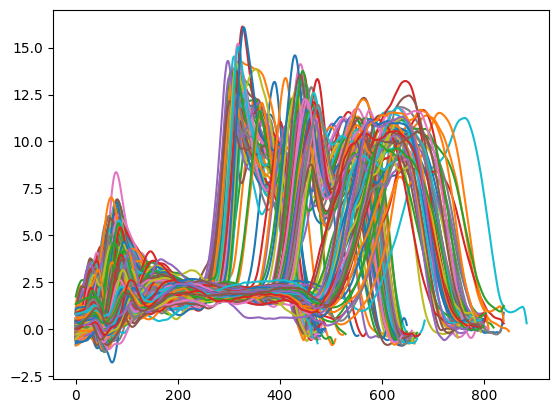

In [78]:
df = pd.read_csv(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_knee_angles.Angles.y.Left-raw.csv")
df[df['start_frame']>1000]
df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
df_only_float_values = df_only_float_values.astype(float)

df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
print(min_length)
b, a = butter(2, 6, fs=100, btype='low')
subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
subset_signal = subset_signal.reset_index(drop=True)

subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        gait_cycle_1 = upsample(gait_cycle_1,100,500)
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)
        plt.plot(float_array_gait_cycle)

In [6]:
signal_length,eeg_set,time_lapses = plot_dtw_align_gait_signals(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_knee_angles.Angles.y.Left-raw.csv",21,raw)

(141, 61, 445)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [7]:
eeg_set.shape

(141, 61, 445)

In [ ]:
eeg_raw.times

In [55]:
info = mne.create_info(raw.info['ch_names'],eeg_set[0,:].shape[1])
eeg_raw = mne.io.RawArray(eeg_set[1,:],info)

Creating RawArray with float64 data, n_channels=61, n_times=445


    Range : 0 ... 444 =      0.000 ...     0.998 secs
Ready.


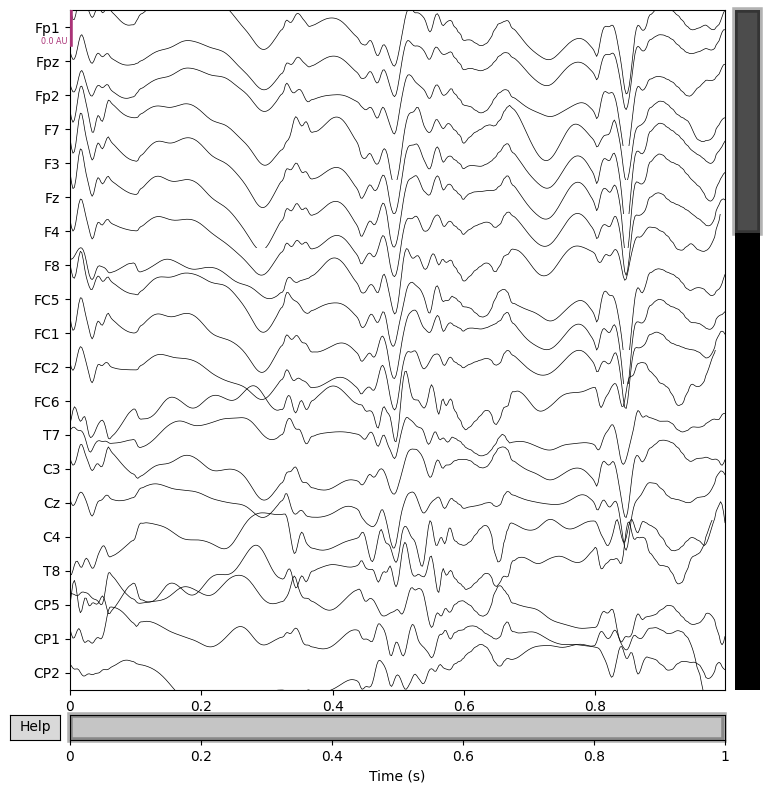

In [53]:
eeg_raw.plot(scalings=3e-6)
plt.show()

In [39]:
reconstructed_eeg_data = np.zeros((eeg_set.shape[1],eeg_set.shape[2]*eeg_set.shape[0]))
for i in range(eeg_set.shape[0]):
    low_idx = i*eeg_set.shape[2]
    high_idx = (i+1)*eeg_set.shape[2]
    reconstructed_eeg_data[:,low_idx:high_idx] = eeg_set[i]


In [44]:
reconstructed_eeg = mne.io.RawArray(reconstructed_eeg_data,info)


Creating RawArray with float64 data, n_channels=61, n_times=62745
    Range : 0 ... 62744 =      0.000 ...   140.998 secs
Ready.


In [ ]:
reconstructed_eeg.times[445*2:444+445*2]

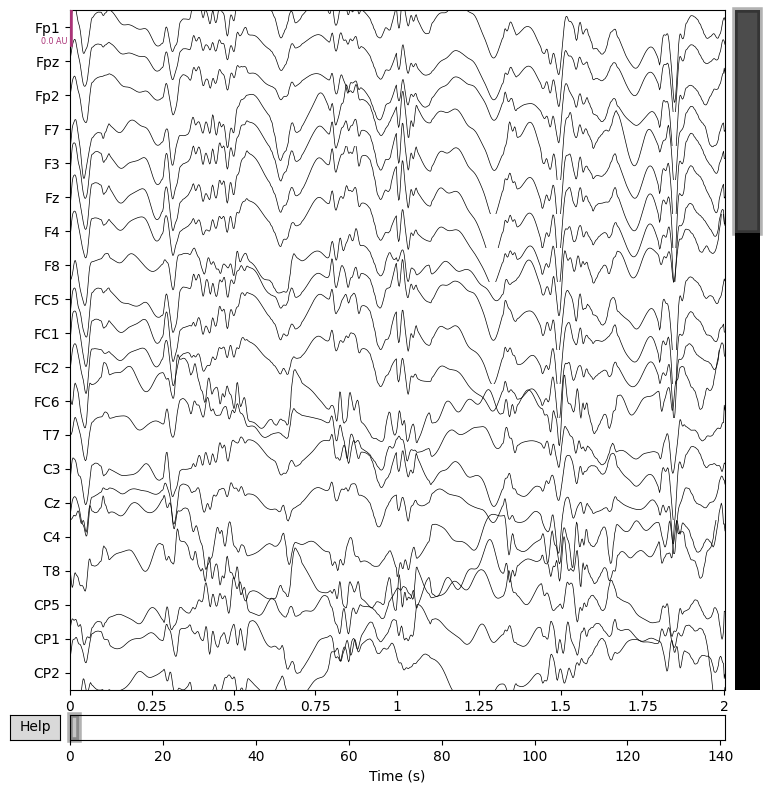

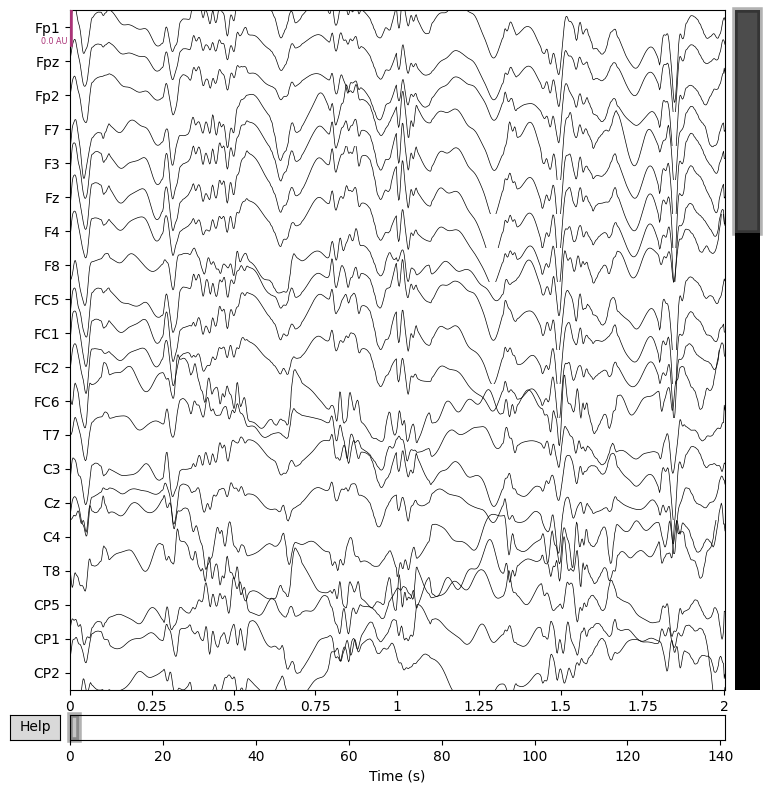

In [51]:
reconstructed_eeg.plot(duration=2,scalings=3e-6)

In [ ]:
plot_dtw_align_gait_signals(r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_knee_angles.Angles.y.Left-raw.csv",21)

In [59]:
file_path = r"C:\Users\haiou\Documents\Cereneo\Data\gaitalytics_data\S4\out\S4_1206202301FBroad-left_knee_angles.Angles.y.Left-raw.csv"
df = pd.read_csv(file_path)
df_only_float_values = df.drop(
    columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
df_only_float_values = df_only_float_values.astype(float)

df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)

subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
subset_signal = subset_signal.reset_index(drop=True)

subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
mean_per_column = subset_signal_only_float_values.mean(axis=0)
mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
reference_signal = subset_signal_only_float_values.iloc[21]
reference_signal = reference_signal[~np.isnan(reference_signal)]
reference_signal = resample(reference_signal, min_length)

b, a = butter(2, 6, fs=100, btype='low')
reference_signal_filt = filtfilt(b, a, reference_signal)
reference_signal_filt = reference_signal_filt.astype(float)

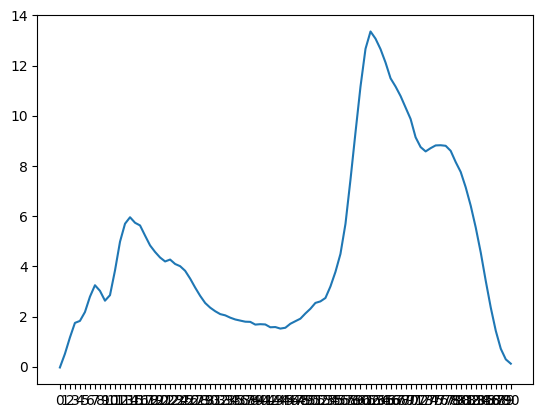

In [58]:
signal = subset_signal_only_float_values.iloc[21]
signal = signal[~np.isnan(signal)]
plt.plot(signal)

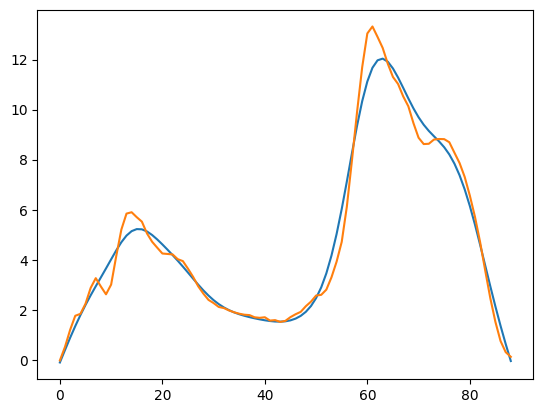

In [60]:
plt.plot(reference_signal_filt)
plt.plot(reference_signal)

# Annotate EEG

Used Annotations descriptions: ['Impedance', 'boundary', 's1']


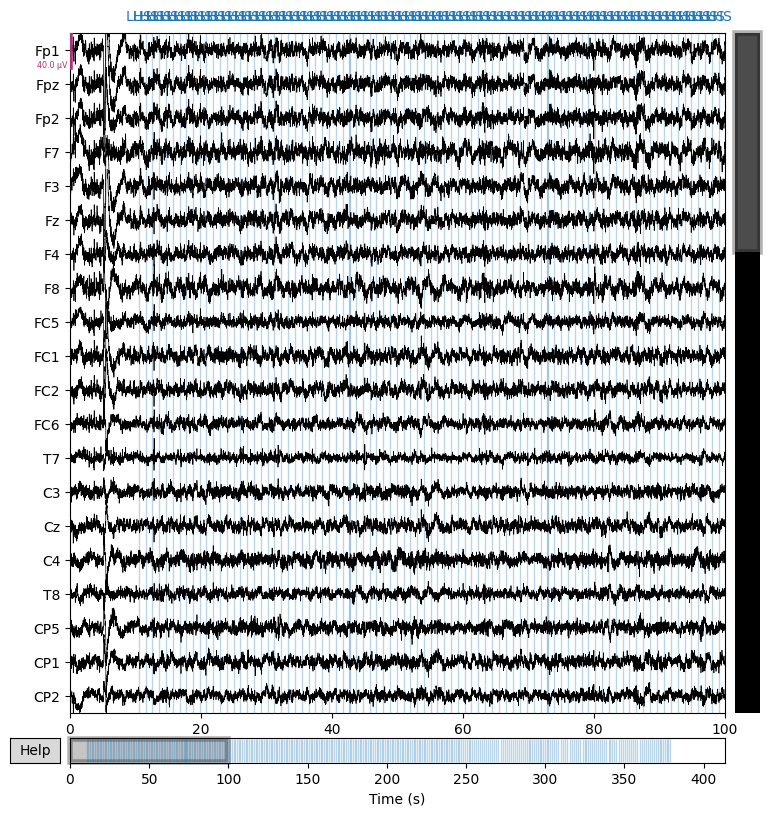

In [90]:
file_path = get_parameter_path(5,'FB','knee','angles','left','y','Left-normalised')
raw_annotated = annotate_eeg(raw,file_path)
raw_annotated.plot(start=0,duration = 100)
plt.show()

In [119]:
mne.export.export_raw(r"C:/Users/haiou/Documents/Cereneo/Data/5_single-subject-EEG-analysis/sub-5/raw_annotated_mne.set",raw_annotated)

Reading 0 ... 206718  =      0.000 ...   413.436 secs...


# Align EEG

In [95]:
file_path  = get_parameter_path(5,'FB','knee','angles','left','y','Left-normalised')
epochs,epochs_resampled,epochs_ica_resampled = align_eeg(file_path,raw,[])

Used Annotations descriptions: ['Impedance', 'boundary', 's1']


In [97]:
print(epochs[100].shape)
print(epochs_resampled[100].shape)


(62, 535)
(62, 794)


In [98]:
info = mne.create_info(raw.info['ch_names'],epochs_resampled[0].shape[1])
single_epoch = mne.io.RawArray(epochs_resampled[0],info)
eeg = reconstruct_eeg(raw,epochs_resampled)

Creating RawArray with float64 data, n_channels=62, n_times=794
    Range : 0 ... 793 =      0.000 ...     0.999 secs
Ready.
Creating RawArray with float64 data, n_channels=62, n_times=262020
    Range : 0 ... 262019 =      0.000 ...   329.999 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.579 (s)


C:\Users\haiou\AppData\Local\Temp\ipykernel_147392\2068569893.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg.plot_psd(fmax=50)
c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


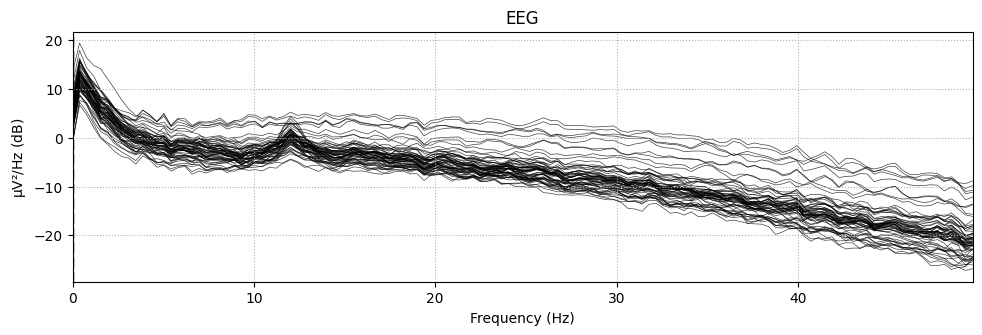

In [99]:
eeg.plot_psd(fmax=50)
plt.show()

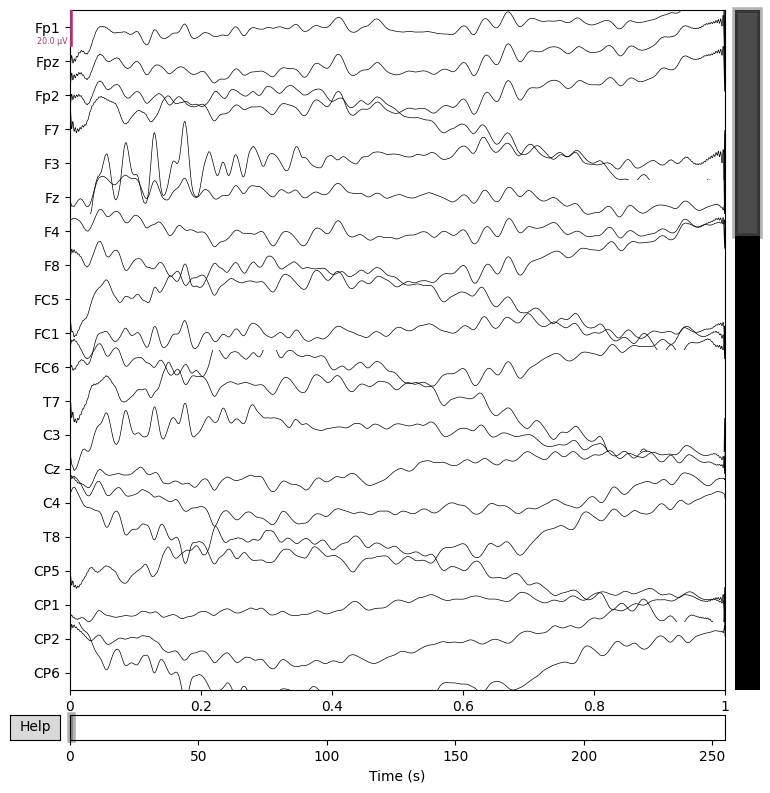

<Figure size 640x480 with 0 Axes>

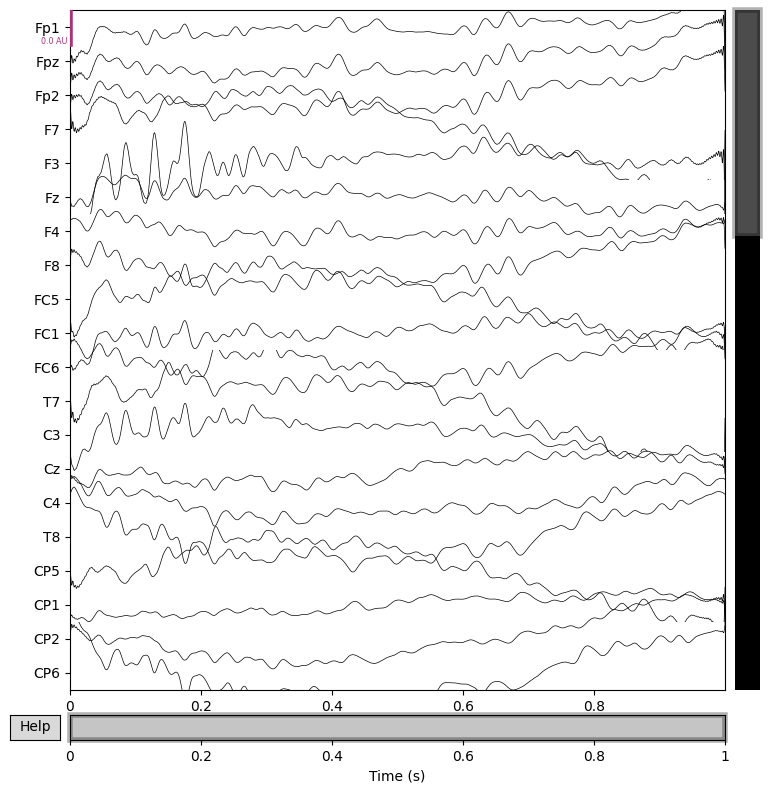

NameError: name 'raw_annotated' is not defined

In [18]:
eeg.plot(duration=1,scalings=1e-5)
plt.show()
plt.figure()
single_epoch.plot(duration=1,scalings=1e-5)
plt.show()
raw_annotated.plot(start=76.78,duration=5,scalings=1e-5)
plt.show()

In [35]:
eeg.times[epochs_resampled.shape[2]]

1.0

# Align motion

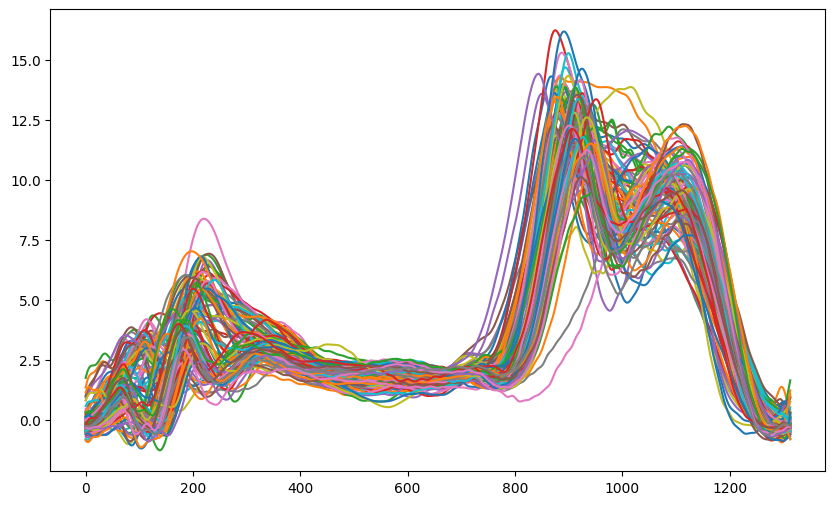

In [47]:
align_motion(file_path,raw,epochs_resampled)

# Events

Used Annotations descriptions: ['LHS']
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 330 events and 953 original time points ...
2 bad epochs dropped


C:\Users\haiou\AppData\Local\Temp\ipykernel_147392\3552262313.py:2: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot(picks=epochs.ch_names)


Using data from preloaded Raw for 20 events and 953 original time points ...


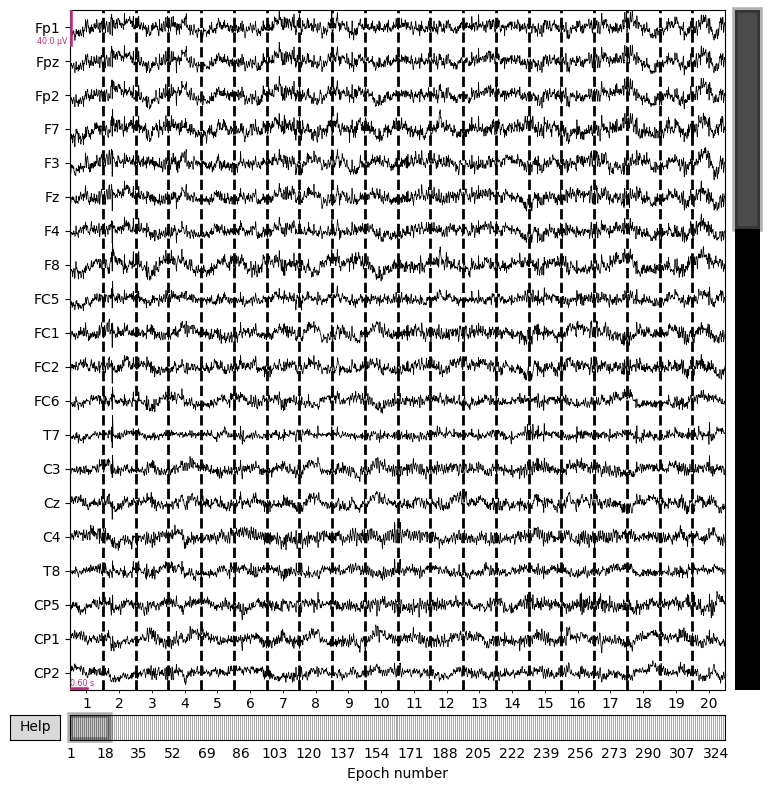

In [100]:
epochs = get_epoch(eeg,epochs_resampled)
epochs.plot(picks=epochs.ch_names)
montage = mne.channels.make_standard_montage('standard_1005', head_size='auto')
epochs.set_montage(montage)
plt.show()

# ERPs

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


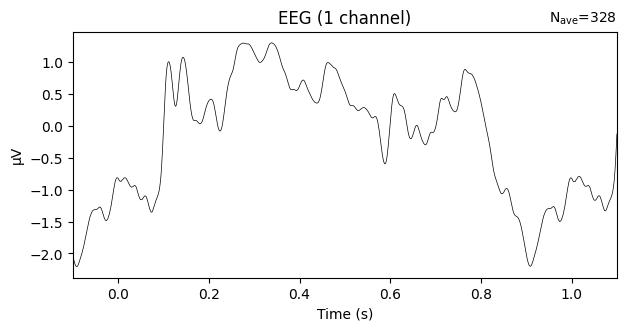

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


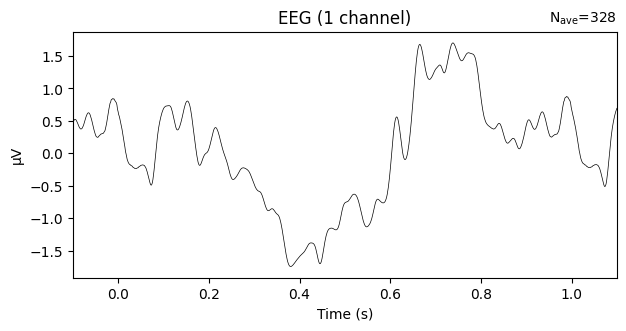

In [101]:
l_c3 = epochs['LHS'].average(picks=['C3']
)
fig1 = l_c3.plot(spatial_colors=True)
l_c4 = epochs['LHS'].average(picks=['C4']
)
fig2 = l_c4.plot(spatial_colors=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


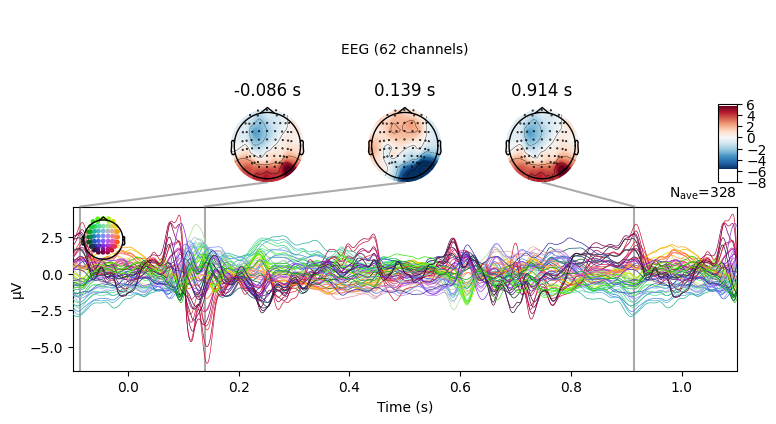

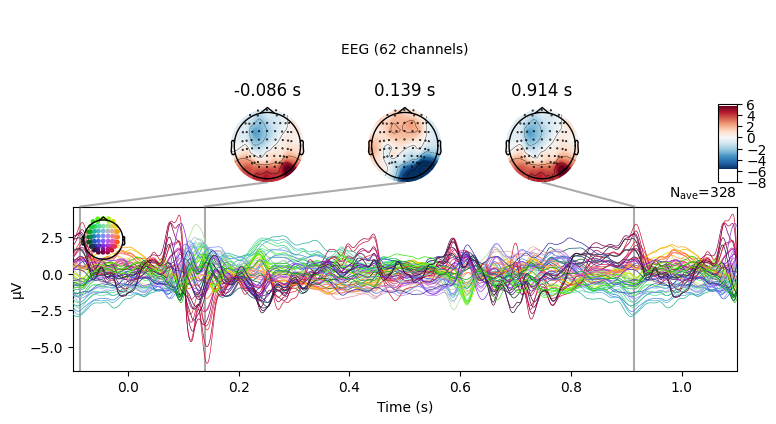

In [102]:
erps = epochs['LHS'].average()
erps.plot_joint()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


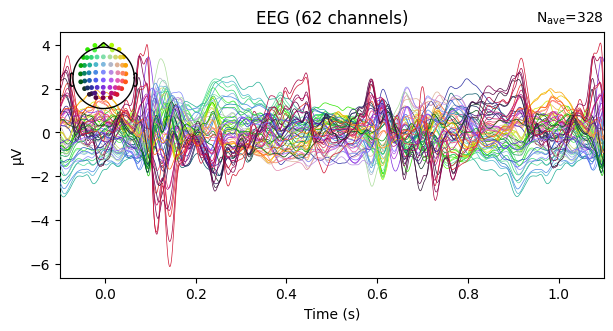

In [103]:
epochs['LHS'].average().plot()
plt.show()

## ERDS

In [105]:
epochs_erds = epochs.copy().load_data()
pick_chs = [ch for ch in epochs_erds.ch_names if ch[0] == 'C']
epochs_erds.pick_channels(pick_chs)

Using data from preloaded Raw for 328 events and 953 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Epochs |  328 events (all good), -0.0994962 – 1.0995 s, baseline off, ~33.4 MB, data loaded,
 'LHS': 328>

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


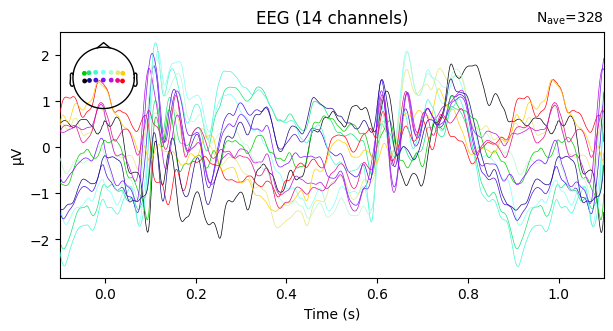

In [106]:
epochs_erds['LHS'].average().plot()
plt.show()

Using data from preloaded Raw for 328 events and 953 original time points ...
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


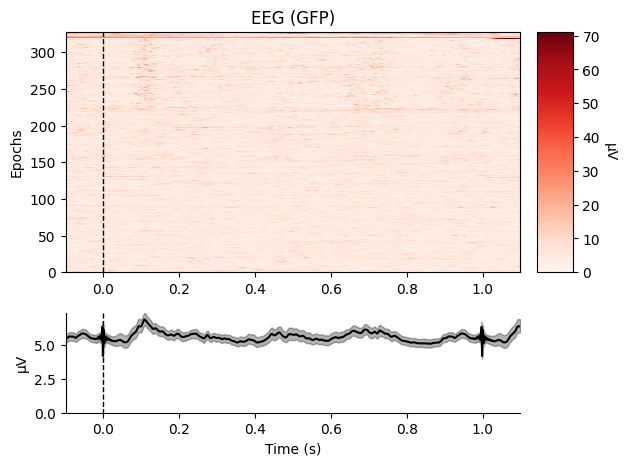

In [107]:
epochs['LHS'].plot_image()
plt.show()

In [108]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = 0 
tmax = 1
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

In [109]:
ch_names = epochs.ch_names
picked_chs = [x for x in ch_names if x[0] == 'C']
epochs.load_data()
epochs.pick(picked_chs)
baseline = (-0.1,0)
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                            return_itc=False, average=False, decim=2,picks=epochs.ch_names)



Using data from preloaded Raw for 328 events and 953 original time points ...
Not setting metadata


In [110]:
tfr.data

array([[[[1.42056184e-10, 1.42162720e-10, 1.42337438e-10, ...,
          9.28110510e-10, 9.14156464e-10, 9.02630737e-10],
         [3.11532709e-11, 3.02205760e-11, 2.91064424e-11, ...,
          8.03810953e-10, 7.96548938e-10, 7.89384375e-10],
         [3.55268646e-11, 3.54721919e-11, 3.54388608e-11, ...,
          6.37430175e-10, 6.32753176e-10, 6.28846052e-10],
         ...,
         [7.11746305e-12, 7.16049116e-12, 7.49008407e-12, ...,
          1.78715838e-11, 1.76408099e-11, 1.77823980e-11],
         [9.80516026e-12, 1.05031761e-11, 1.14460011e-11, ...,
          1.95335587e-11, 1.83384271e-11, 1.78016705e-11],
         [6.40512684e-12, 6.89006749e-12, 7.37641401e-12, ...,
          1.60548577e-11, 1.52057926e-11, 1.46442904e-11]],

        [[8.44773437e-10, 8.42262908e-10, 8.39310943e-10, ...,
          1.45766075e-10, 1.41026220e-10, 1.37326202e-10],
         [7.64155835e-11, 7.65883550e-11, 7.67492234e-11, ...,
          1.62988119e-10, 1.61133302e-10, 1.59524344e-10],
        

C:\Users\haiou\AppData\Local\Temp\ipykernel_147392\1863473122.py:1: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmin (-0.0994962 s)
  tfr.crop(tmin-0.1, tmax).apply_baseline(baseline, mode="percent")


Applying baseline correction (mode: percent)
Using a threshold of 1.649527
stat_fun(H1): min=-14.176061 max=14.743726
Running initial clustering …
Found 1 cluster


c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:02<00:00,   34.00it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:02<00:00,   38.26it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.649527


stat_fun(H1): min=-14.176061 max=14.743726
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:02<00:00,   38.13it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:02<00:00,   38.93it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
Using a threshold of 1.649527
stat_fun(H1): min=-12.785555 max=14.318707
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:02<00:00,   40.37it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:02<00:00,   39.81it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.649527
stat_fun(H1): min=-12.785555 max=14.318707
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:02<00:00,   38.47it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:02<00:00,   38.17it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
Using a threshold of 1.649527
stat_fun(H1): min=-14.793691 max=15.265973
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:02<00:00,   38.38it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:02<00:00,   39.67it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.649527


stat_fun(H1): min=-14.793691 max=15.265973
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:02<00:00,   39.53it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:02<00:00,   39.52it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


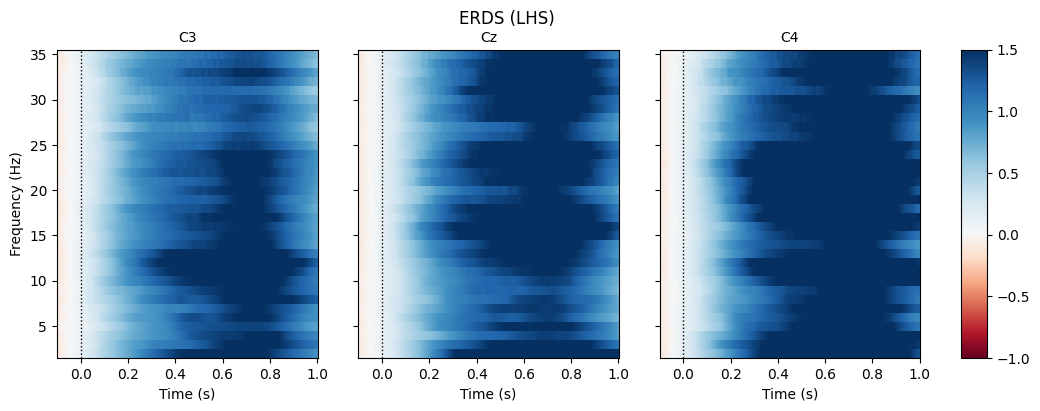

In [111]:
tfr.crop(tmin-0.1, tmax).apply_baseline(baseline, mode="percent")
event_ids = epochs.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

C:\Users\haiou\AppData\Local\Temp\ipykernel_147392\128027316.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


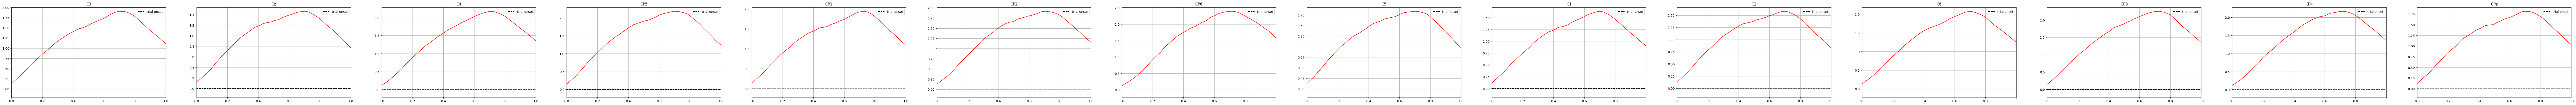

In [112]:
     
channels = tfr.ch_names
trials = list(tfr.event_id.keys())
freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
fig,axs = plt.subplots(1,len(picked_chs))
        
for k,ch in enumerate(channels):
    for trial in trials:
        current_tfr = tfr.copy().pick([ch])
        selection = current_tfr[trial].data[:,:,freq_mask,:]
        avg = np.nanmean(np.mean(selection,axis=2),axis=0)
        axs[k].plot(tfr.times,avg[0],color='red')
    axs[k].grid(True)
    #axs[k].set_ylim([0, 1])
    axs[k].set_xlim([0, 1])
    axs[k].axvline(x = baseline[1], color = 'black',linestyle="--", label = 'trial onset')
    axs[k].axhline(y = 0., color = 'black',linestyle="--")
    axs[k].legend()
    axs[k].set_title(ch)
fig.tight_layout()
fig.set_figwidth(len(picked_chs)*10)
#fig.suptitle(cond, fontsize=10)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
plt.show()


In [113]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


ValueError: items in new_categories are not the same as in old categories

## TFR time warping

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


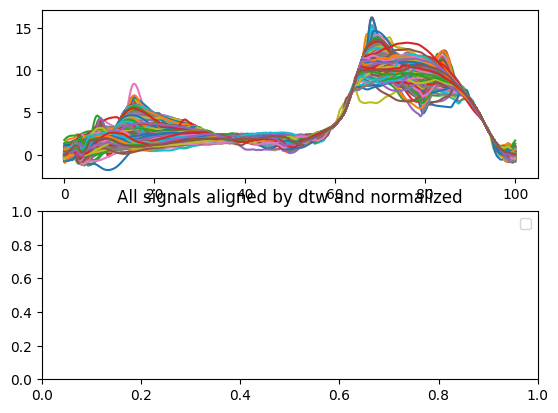

In [ ]:
new_set = time_warp_signal(tfr['LHS'].data,file_path,reference_id=21)

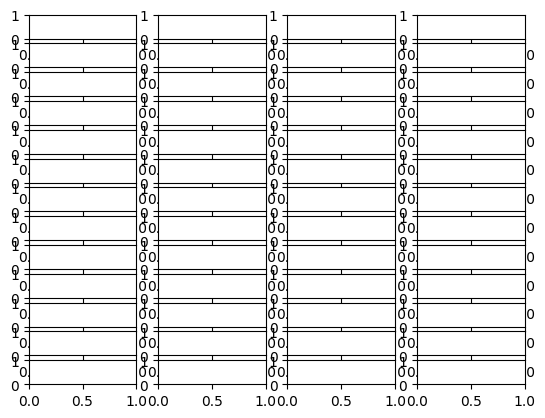

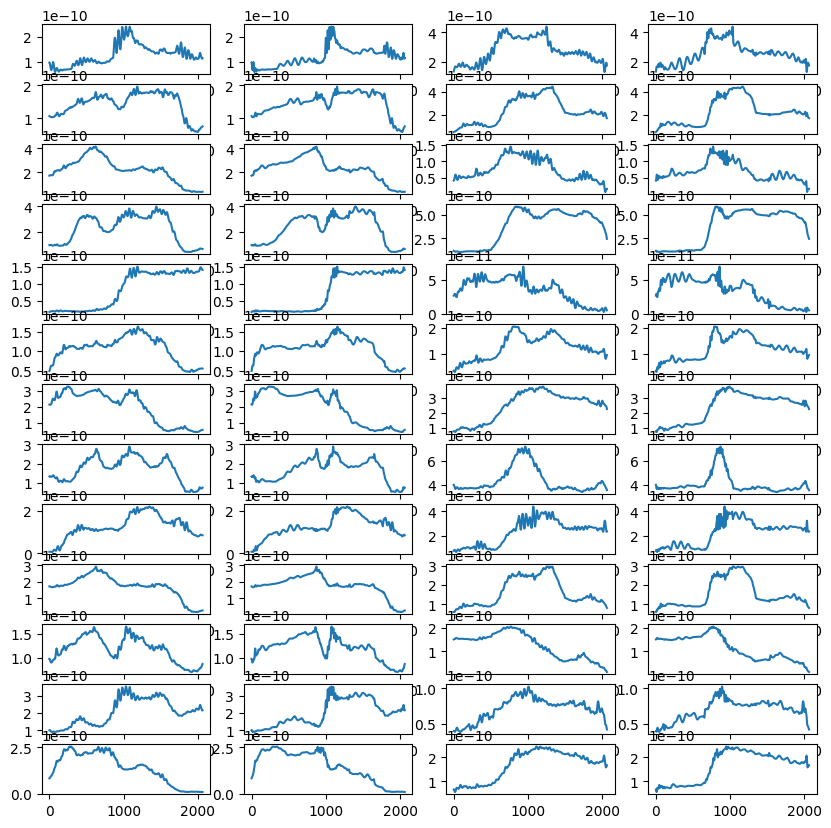

In [ ]:
fig,axs = plt.subplots(new_set.shape[1],4,figsize=(10,10))
df = pd.read(file_path)
for i in range(new_set.shape[1]):
    
    freq = 33
    axs[i,1].plot(new_set[100,i,freq,:])
    axs[i,0].plot(tfr.data[100,i,freq,:])
    axs[i,3].plot(new_set[150,i,freq,:])
    axs[i,2].plot(tfr.data[150,i,freq,:])
plt.show()

In [ ]:
idxs = (new_set == 0)

In [ ]:
tfr.data[idxs]

array([5.62019279e-09, 5.62450103e-09, 5.62893001e-09, ...,
       1.50208494e-10, 1.50477277e-10, 1.50872379e-10])

In [ ]:
new_tfr = tfr.copy()
new_tfr.data = new_set

In [ ]:
new_tfr.data[idxs] = tfr.data[idxs]

In [ ]:
np.argwhere(np.isnan(new_tfr.data))

array([], shape=(0, 4), dtype=int64)

Applying baseline correction (mode: percent)
Using a threshold of 1.650923
stat_fun(H1): min=-21.834381 max=15.429943
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:11<00:00,    8.31it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:11<00:00,    8.79it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650923


stat_fun(H1): min=-21.834381 max=15.429943
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:11<00:00,    8.75it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:10<00:00,    9.45it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
Using a threshold of 1.650923
stat_fun(H1): min=-18.288179 max=12.625146
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:10<00:00,    9.18it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:10<00:00,    9.24it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650923


stat_fun(H1): min=-18.288179 max=12.625146
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:10<00:00,    9.40it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:09<00:00,    9.92it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
Using a threshold of 1.650923
stat_fun(H1): min=-19.874364 max=13.669230
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:10<00:00,    9.01it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:09<00:00,   10.26it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650923
stat_fun(H1): min=-19.874364 max=13.669230
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:09<00:00,    9.93it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:09<00:00,   10.11it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


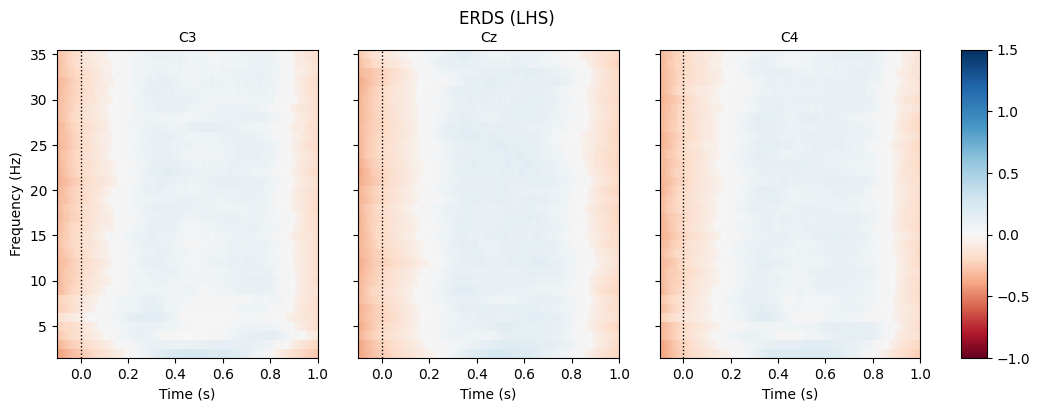

In [ ]:
baseline = (None,None)
new_tfr.crop(tmin-0.1, tmax).apply_baseline(baseline, mode="percent")
event_ids = epochs.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = new_tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [36]:
new_tfr.ch_names

['C3',
 'Cz',
 'C4',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'C5',
 'C1',
 'C2',
 'C6',
 'CP3',
 'CP4']